In [ ]:
import warnings
warnings.filterwarnings("ignore")

#!pip3 install plotly.express
#import sys
#!conda install --yes --prefix {sys.prefix} plotly
!conda install -c anaconda py-xgboost


Solving environment: done

## Package Plan ##

  environment location: /Users/Vaibhav_Beohar/anaconda3

  added / updated specs:
    - py-xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  anaconda
    ca-certificates-2020.1.1   |                0         132 KB  anaconda
    certifi-2019.11.28         |           py37_0         156 KB  anaconda
    conda-4.8.3                |           py37_0         3.0 MB  anaconda
    libxgboost-0.90            |       h0a44026_1         2.4 MB  anaconda
    openssl-1.1.1d             |       h1de35cc_4         3.4 MB  anaconda
    py-xgboost-0.90            |   py37h0a44026_1          77 KB  anaconda
    ------------------------------------------------------------
                                           Total:         9.2 MB

The following NEW packages will be INSTALLED:

  _py

### Import Packages and define functions

In [ ]:
import multiprocessing as mp
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
sns.set_context('notebook')
sns.set_style('white')
%matplotlib inline

#import utils
from ipywidgets import interact, fixed


from sklearn.svm import LinearSVR, SVR
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import Ridge
from sklearn import linear_model
from scipy import stats
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
np.random.seed(0)

### EDA and Feature Engineering

In [ ]:
# load csv
df = pd.read_csv('train_cleaned.csv',index_col=0)
df.head()

In [ ]:
# create dummies for some variables that should have them
df2 = pd.get_dummies(data =df, columns = ['city', 'room_type', 'property_type'])

# grab the new dummies
df2 = df2.iloc[:, 43::]

# concat into CSV DF
df = pd.concat([df, df2], axis = 1)

# remove string vars
df = df.select_dtypes(exclude=[np.object])

# drop na
df = df.dropna(axis = 0)

# prepare X, y
y = df['log_price'].values
X = df.drop(['log_price'], axis = 1).values

# shuffle data
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, y = X[shuffle], y[shuffle]

# split data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state = 42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_full, y_train_full, random_state = 42)

In [ ]:
sns.distplot(np.exp(y_train), kde=False)
plt.title('Original dependent variable Histogram - AirBnB price');

In [ ]:
sns.distplot(y_train, kde=False)
plt.title('Log transformed dependent variable Histogram - AirBnB price');

### Nominal Variables

In [ ]:
nominal = ['internet','air_conditioning','breakfast','parking','kitchen','pool','pets_allowed',
           'checkin_24','tv','laundry','accommodates','bathrooms','flexible','moderate','strict',
           'cleaning_fee','host_has_profile_pic','host_identity_verified','instant_bookable','longitude',
           'miles_city_center','cc_latitude','cc_longitude','number_of_reviews','review_scores_rating',
           'bedrooms','beds']

df_quant = df[nominal]

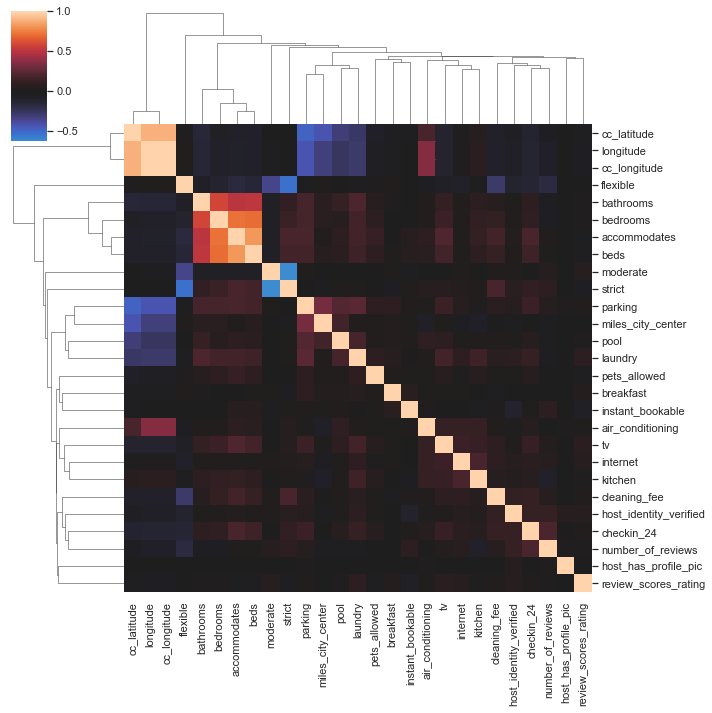

In [83]:
sns.clustermap(df_quant.corr(), center=0)

### Modeling

In [ ]:

# scorer
mse = make_scorer(metrics.mean_squared_error)

# functions
# confidence interval
def confidence_interval(confidence_level, predicted_y, y_test):
    confidence = confidence_level
    squared_errors = (predicted_y - y_test) ** 2
    return np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                             loc = squared_errors.mean(),
                             scale = stats.sem(squared_errors)))

# cross val scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", round(scores.mean(), 3))
    print("Standard deviation:", round(scores.std(), 3))


# result storage
model_name = []
RMSE = []
CI = []
cross_val_mean = []

In [ ]:

################## Base Model: Linear Regression ##################
# fit a linear regression model
lm = LinearRegression() # instantiate lm
lm.fit(X_train_full, y_train_full); # fit lm
r2_lm = lm.score(X_train_full, y_train_full) # x, y

# show r2 of regression model
print(round(r2_lm, 3), 'is the r-squared for the regression model')

# generate predictions
predicted_y = lm.predict(X_test) # prediction

# metrics
lm_RMSE = mean_squared_error(y_test, predicted_y, squared = False)
print('Root Mean Squared Error:', round(lm_RMSE, 3))

# confidence interval for RMSE
lm_ci = confidence_interval(0.95, predicted_y, y_test)
print('The 95% confidence interval for our RMSE is:', np.round(lm_ci, 3))

# cross-val on dev data
scores = cross_val_score(lm, X_dev, y_dev,
                         scoring = "neg_mean_squared_error", # expects utility fx
                         cv = 10) # 10 folds

rmse_scores = np.sqrt(-scores) # sqrt for RMSE

display_scores(rmse_scores)
# dev data contains some very messed up observations,
# or lm is just struggling to predict,
# as evidenced by cross-val

display_scores(rmse_scores)

# append results
model_name.append('linear model')
RMSE.append(lm_RMSE)
CI.append(lm_ci)
cross_val_mean.append(rmse_scores.mean())